## Getting Started
In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations. Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with. While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features.

The dataset for this project originates from the UCI Machine Learning Repository. The datset was donated by Ron Kohavi and Barry Becker, after being published in the article "Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid". You can find the article by Ron Kohavi online. The data we investigate here consists of small changes to the original dataset, such as removing the 'fnlwgt' feature and records with missing or ill-formatted entries.



## Exploring the Data

In [49]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=10))


,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K
5,37,Private,Masters,14.0,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.0,0.0,40.0,United-States,<=50K
6,49,Private,9th,5.0,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0.0,0.0,16.0,Jamaica,<=50K
7,52,Self-emp-not-inc,HS-grad,9.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,45.0,United-States,>50K
8,31,Private,Masters,14.0,Never-married,Prof-specialty,Not-in-family,White,Female,14084.0,0.0,50.0,United-States,>50K
9,42,Private,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178.0,0.0,40.0,United-States,>50K


In [52]:
# DONE: Total number of records
n_records = len(data)

# DONE: Number of records where individual's income is more than $50,000
n_greater_50k = data.income.value_counts()['>50K'] # len(data[data['income'] == '>50K'])

# DONE: Number of records where individual's income is at most $50,000
n_at_most_50k = data.income.value_counts()['<=50K'] # len(data[data['income'] == '<=50K'])

# DONE: Percentage of individuals whose income is more than $50,000
greater_percent = float(n_greater_50k)/float(n_records)*100

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent))


Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


## Implementation: Data Exploration

A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:



/home/imran/Udacity-DSND/Supervised-Learning/Finding-Donors/visuals.py:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


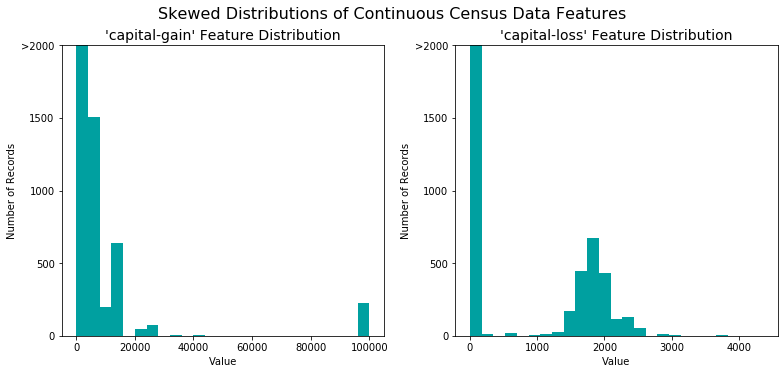

In [53]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)



### Featureset Exploration

age: continuous.
workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
education-num: continuous.
marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
race: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other.
sex: Female, Male.
capital-gain: continuous.
capital-loss: continuous.
hours-per-week: continuous.
native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

### Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as preprocessing. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number. Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: 'capital-gain' and 'capital-loss'.



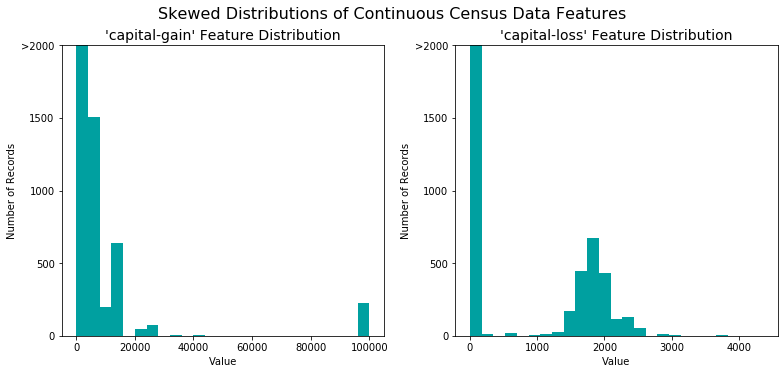

In [54]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

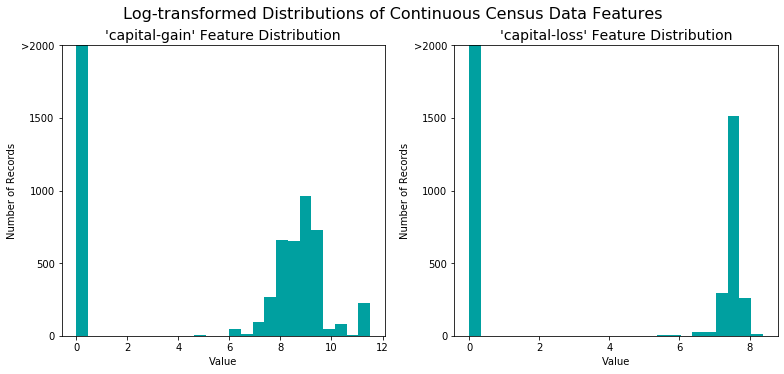

In [55]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_raw[skewed] = data[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_raw, transformed = True)

### Normalizing Numerical Features

In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as 'capital-gain' or 'capital-loss' above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below

In [56]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_raw[numerical] = scaler.fit_transform(data[numerical])

# Show an example of a record with scaling applied
display(features_raw.head(n = 1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.30137,State-gov,Bachelors,0.8,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States


### Implementation: Data Preprocessing

From the table in Exploring the Data above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called categorical variables) be converted. One popular way to convert categorical variables is by using the one-hot encoding scheme. One-hot encoding creates a "dummy" variable for each possible category of each non-numeric feature. For example, assume someFeature has three possible entries: A, B, or C. We then encode this feature into someFeature_A, someFeature_B and someFeature_C.

In [58]:
# DONE: One-hot encode the 'features_raw' data using pandas.get_dummies()
features = pd.get_dummies(features_raw)

# DONE: Encode the 'income_raw' data to numerical values
income = income_raw.apply(lambda x: int(x == '>50K'))

# Print the number of features after one-hot encoding
encoded = list(features.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

# Uncomment the following line to see the encoded feature names
print(encoded)


103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ A

### Shuffle and Split Data

Now all categorical variables have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.


In [61]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, income, test_size = 0.2, random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))


Training set has 36177 samples.
Testing set has 9045 samples.


In [63]:
n_tp = float(n_greater_50k)
n_tn = 0.
n_fp = float(n_at_most_50k)
n_fn = 0.
n_total = float(n_records)
n_beta2 = 0.5 ** 2

# DONE: Calculate accuracy - (TP+TN) / TOTAL POULATION
accuracy = (n_tp + n_tn) / n_records

# DONE: Calculate F-score using the formula above for beta = 0.5
my_precision = n_tp / (n_tp + n_fp)
my_recall = n_tp / (n_tp + n_fn)

fscore = (1 + n_beta2) * ((my_precision * my_recall) / ((n_beta2 * my_precision ) + my_recall) )

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore)) 


Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


## Question 2 - Model Application

List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen

Describe one real-world application in industry where the model can be applied. (You may need to do research for this — give references!)
What are the strengths of the model; when does it perform well?
What are the weaknesses of the model; when does it perform poorly?
What makes this model a good candidate for the problem, given what you know about the data?
Answer:

Decision Trees
Decision trees have a huge number of applications, such as recommendation systems. Personally I believe one of the greatest strengths of decision trees is that it can be understood by humans and can provide intuitions which are not always obvious by a simple inspection of data. Using a single decision tree is not a good option if the underlying structure of the problem is too complex. I want to use decision trees for this model to check the feature importance to better understand the problem.

KNN
K-NN is a nonparametric machine learning algorithm and one interesting use case for it is Classification of Hear Disease. Being a nonparametric model, its great strenght is on the fact that it derives its predictions from the data itself, and training time is very small. On the other hand, query performance is very slow and grows exponentialy with the size of the dataset. I want to try this algorithm to see how it compares to parametric models.

Adaboost
Adaboost, or Adaptive Boosting is an ensamble method that combines weak learners in a weighted average, and facial expression recognition is one of it's possible applications. One of its strengths is that it is less susceptible to overfitting, although it can be more sensitive to noisy data and outliers. The reason I wan't to try Adaboost in this problem is because I've had good results with other problems before.

Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section. In the code block below, you will need to implement the following:

Import fbeta_score and accuracy_score from sklearn.metrics.
Fit the learner to the sampled training data and record the training time.
Perform predictions on the test data X_test, and also on the first 300 training points X_train[:300].
Record the total prediction time.
Calculate the accuracy score for both the training subset and testing set.
Calculate the F-score for both the training subset and testing set.
Make sure that you set the beta parameter!

In [64]:
# DONE: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # DONE: Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # DONE: Calculate the training time
    results['train_time'] = end - start
        
    # DONE: Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # DONE: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # DONE: Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # DONE: Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # DONE: Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=0.5)
        
    # DONE: Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results


In [ ]:
# DONE: Import the three supervised learning models from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier

# DONE: Initialize the three models
clf_A = DecisionTreeClassifier(random_state=0)
clf_B = KNeighborsClassifier()
clf_C = AdaBoostClassifier(random_state=0)

# DONE: Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 = len(X_train)/100
samples_10 = len(X_train)/10
samples_100 = len(X_train)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)


In [ ]:
# DONE: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer

# DONE: Initialize the classifier
clf = AdaBoostClassifier(random_state=0)

# DONE: Create the parameters list you wish to tune
parameters = {
    'n_estimators': [400, 600, 800],
    'learning_rate': [1.5, 2, 2.5]
}

# DONE: Make an fbeta_score scoring object
def f_beta_wrapper(y_true, y_pred):
    return fbeta_score(y_pred, y_true, 0.5)

scorer = make_scorer(f_beta_wrapper)

# DONE: Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf, param_grid=parameters, scoring=scorer)

# DONE: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------") 
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))) 
print("\nOptimized Model\n------") 
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))) 
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

print("\nBest Params", best_clf) 


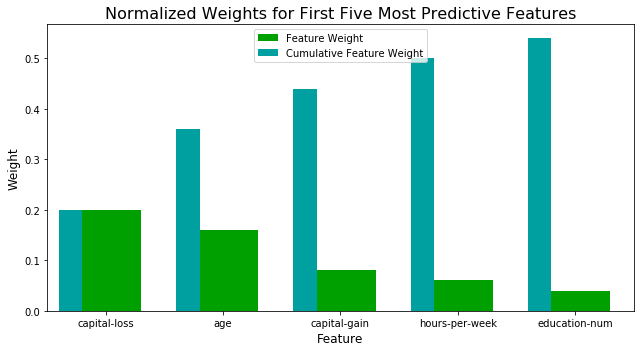

In [70]:
# DONE: Import a supervised learning model that has 'feature_importances_'
# No Need. My best_clf (AdaBoost) has feature_importances_

# DONE: Train the supervised model on the training set 
model = AdaBoostClassifier()
model.fit(X_train, y_train)

# DONE: Extract the feature importances
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)


In [ ]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))) 
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions))) 
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

## Question 8 - Effects of Feature Selection¶
How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?
If training time was a factor, would you consider using the reduced data as your training set?

Answer: The difference in accuracy and score is very small, just 0,026 and 0,044 respectively. I would definitely consider it a valid trade off for the time saved.

